In [2]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [3]:
if(os.path.split(os.getcwd())[1] == "CBIR"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = False

Current Working Directory: progettoVIPM


In [4]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset
from utils.extractNeuralFeatures import extract_features
from utils.extractNeuralFeatures import extrac_features_from_unlabled_dataset

In [5]:
chosen_net = networks.ALEXNET
linear_layers_to_remove = 3
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers = extract_features(train_set=datasets.TRAINING_LABELED,
                                                                                            test_set=datasets.TEST,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 5020
Feature vector shape of Train: (5020, 9216)
Label vector shape of Train: (5020,)
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 11994
Feature vector shape of Test: (11994, 9216)
Label vector shape of Test: (11994,)
---------------------------------------------------------------------------------
Original classification layers:Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
-------------------------------------

In [6]:
chosen_net = networks.ALEXNET
layers_to_remove = 3
X_unlabled_mobi_t, X_unlabled_mobi_n, fine_tune_layers = extrac_features_from_unlabled_dataset(dataset=datasets.TRAINING_UNLABELED,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=layers_to_remove)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in unlabled: 113455
Feature vector shape of unlabled: (113455, 9216)
Label vector shape of unlabled: (113455,)
---------------------------------------------------------------------------------
Original classification layers:Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Classification layers to fine tune:Sequential(
  (0): Linear(in_features=9216, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=4096, out_features=1000, bias=True)
)


In [7]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_ale_n, y_train)

KNeighborsClassifier(n_neighbors=10)

In [8]:
X_unlabled_mobi_n.shape

(113455, 9216)

In [9]:
from torch.utils.data import DataLoader

dataset_holder = ImageDataset(dataset=datasets.TRAINING_UNLABELED, network_input_size=chosen_net.value[0], cuda=cuda)
#loader = DataLoader(dataset=dataset_holder, shuffle=False, batch_size=1)

In [10]:
rs = torch.utils.data.RandomSampler(X_unlabled_mobi_n, num_samples=10)
for s in rs:
    print(s)

69344
33501
112201
55461
66606
4219
48115
94217
113140
42728


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07224289..1.0542186].


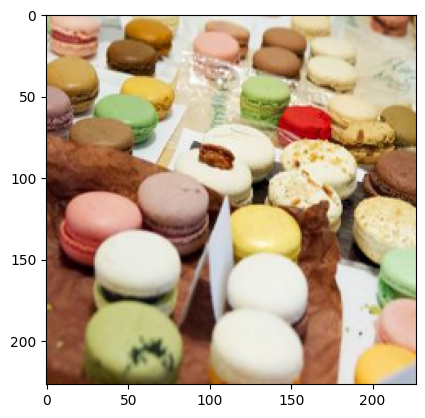

In [11]:
pic42 = dataset_holder[42][0]
image = np.moveaxis(pic42, 0, -1)
plt.figure()
plt.imshow(image)

100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


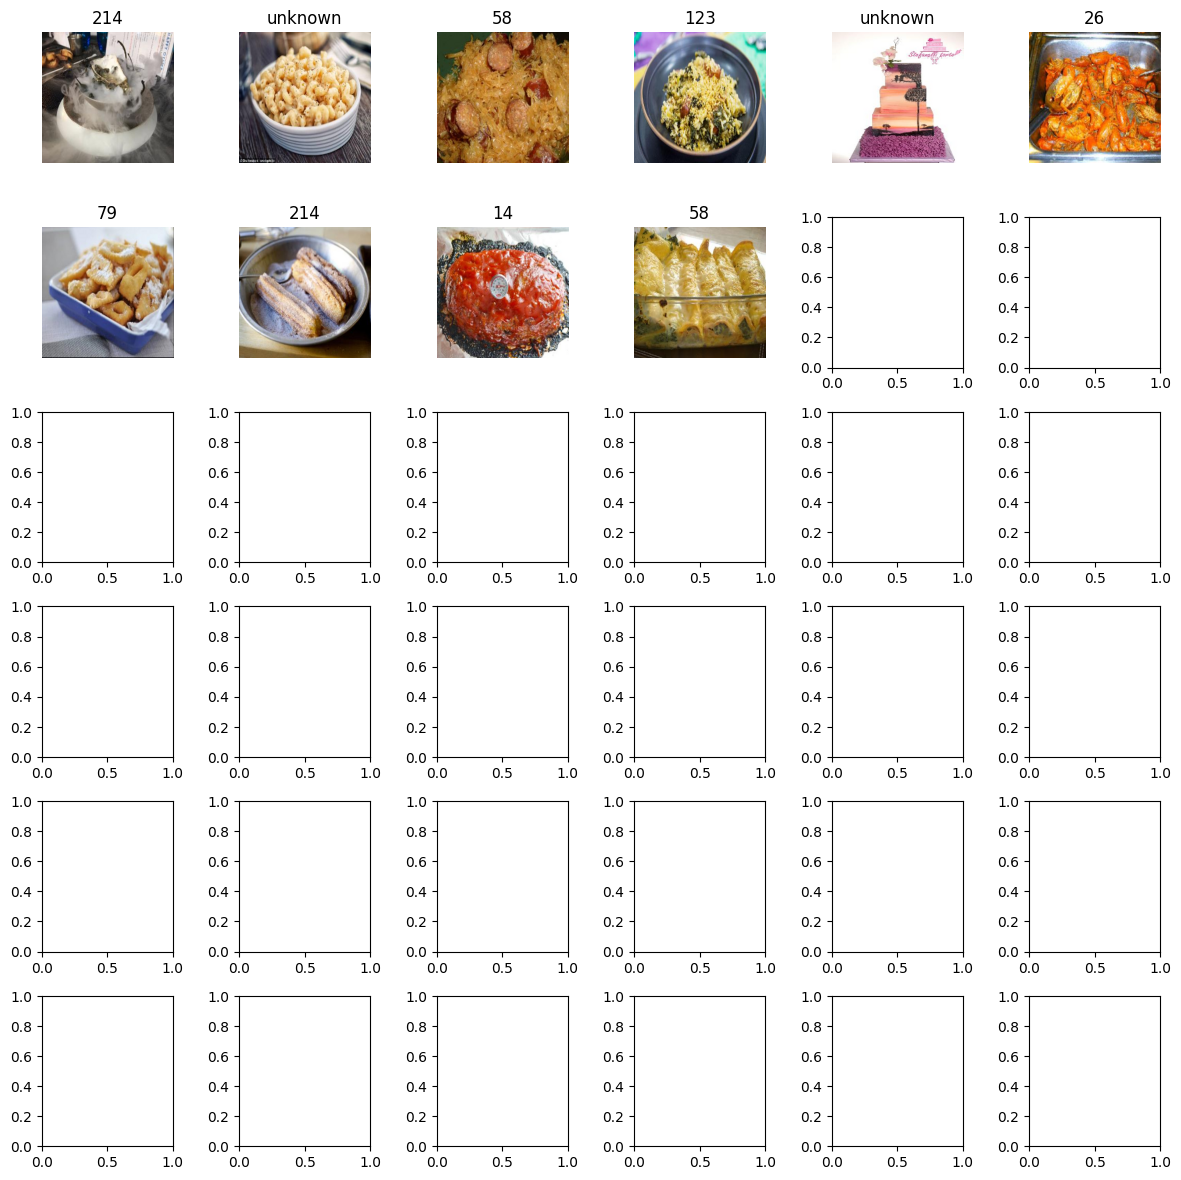

66.54208831787109
[214, 'unknown', 58, 123, 'unknown', 26, 79, 214, 14, 58]


In [14]:

# Function to predict with threshold and progress bar
def knn_predict_with_threshold(knn, dataset_holder, img_dataset_indices, X, early_stop_at, threshold_distance):
    predictions = []
    dists=[]
    i=0
    
    figure, ax = plt.subplots(nrows=6, ncols=6, figsize=(12, 12))
    for sample_index in tqdm(img_dataset_indices):        
        if i>early_stop_at: break

        image = np.moveaxis(dataset_holder[sample_index][0], 0, -1)
        
        distances, _ = knn.kneighbors([X[sample_index]], n_neighbors=knn.n_neighbors)
        if np.min(distances) > threshold_distance:
            predictions.append('unknown')            
            dists.append(-1)
        else:
            prediction = knn.predict([X[sample_index]])
            predictions.append(prediction[0])
            dists.append(np.min(distances))
       

       
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predictions[-1])
        ax.ravel()[i].set_axis_off()
        #plt.figure()
        #plt.imshow(image)
        i+=1
        
    plt.tight_layout()
    plt.show()
    return dists, predictions


dists, predictions = knn_predict_with_threshold(knn, dataset_holder, rs, X_unlabled_mobi_n, 113456, threshold_distance=99)
print(np.mean(dists))
print(predictions)
